# **Waste Material Segregation for Improving Waste Management**

***Author : Keshav Gupta***

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1


In [2]:
# Import essential libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image # For Pillow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import requests
import zipfile
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l2

pd.set_option('display.max_columns', None) # 'None' means display all columns


Load the dataset.

In [3]:
# Load and unzip the dataset

def extract_zip_in_current_location():
    response = requests.get('https://drive.usercontent.google.com/download?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM&export=download&authuser=0&confirm=t&uuid=8a7ccb90-ea5a-47f2-b5bb-eb29f75f9926&at=AN8xHoonSBPl5THR5M6tuy2m-h9L%3A1749906860972')
    response.raise_for_status()
    zip_filename = "data.zip"
    with open(zip_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8199):
            if chunk:
                f.write(chunk)
    # Get the current working directory
    current_directory = os.getcwd()
    print(f"Current working directory: {current_directory}")

    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            print(f"Extracting '{zip_filename}' to '{current_directory}'...")
            zip_ref.extractall(current_directory)
            print("Extraction complete!")

            extracted_items = os.listdir(current_directory)
            print("\nSome items in the current directory after extraction (first 5):")
            for i, item in enumerate(extracted_items[:5]):
                print(f"- {item}")

    except zipfile.BadZipFile:
        print(f"Error: '{zip_filename}' is not a valid zip file or is corrupted.")
    except Exception as e:
        print(f"An unexpected error occurred during extraction: {e}")

In [4]:
extract_zip_in_current_location()

Current working directory: /content
Extracting 'data.zip' to '/content'...
Extraction complete!

Some items in the current directory after extraction (first 5):
- .config
- data.zip
- data
- sample_data


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [5]:
def load_image_and_label(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

    loaded_image_ds = list_ds.map(load_image_and_label)

    print("Displaying the first few elements of the loaded dataset:")
    for image, label in loaded_image_ds.take(3):
        print(f"Image shape: {image.shape}, Label: {class_names[label.numpy()]}")

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [6]:
def load_image_and_label(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

In [7]:
# Get the images and their labels

# Define the path to the dataset directory
data_dir = pathlib.Path("data")

# Create a list of all image file paths and their corresponding labels
image_files = list(data_dir.glob('*/*'))
image_files = [str(path) for path in image_files]

# Get the labels for each image file
image_labels = [pathlib.Path(path).parent.name for path in image_files]

# Create a tf.data.Dataset from the file paths and labels
list_ds = tf.data.Dataset.from_tensor_slices((image_files, image_labels))

image_list = []
label_list = []
loaded_image_ds = list_ds.map(load_image_and_label)

for image, label in loaded_image_ds:
    image_list.append(image.numpy())
    label_list.append(label.numpy())

images_numpy = np.array(image_list)
labels_numpy = np.array(label_list)

print(f"Shape of images_numpy: {images_numpy.shape}")
print(f"Shape of labels_numpy: {labels_numpy.shape}")

Shape of images_numpy: (7625, 256, 256, 3)
Shape of labels_numpy: (7625,)


Perform any operations, if needed, on the images and labels to get them into the desired format.

In [ ]:
isinstance(images_numpy, np.ndarray)

True

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [ ]:
labels_numpy

array([b'Metal', b'Metal', b'Metal', ..., b'Paper', b'Paper', b'Paper'],
      dtype='|S10')

<ipython-input-9-1795400581>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_numpy, palette='viridis', legend=False)


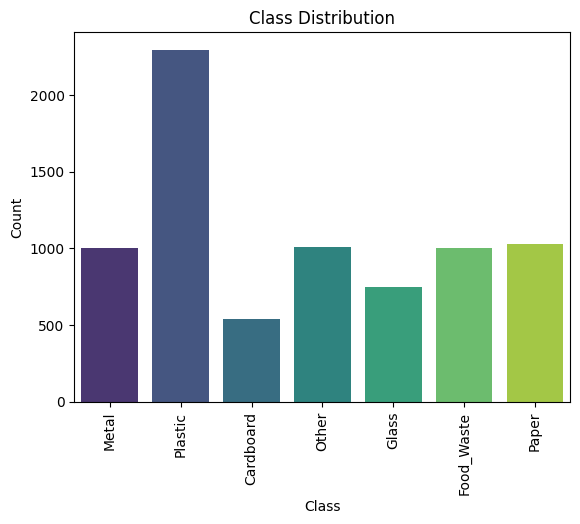

In [ ]:
# Visualise Data Distribution
sns.countplot(x=labels_numpy, palette='viridis', legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
unique_numerical_labels = sorted(np.unique(labels_numpy))
plt.xticks(rotation=90)

plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [ ]:
# Visualise Sample Images (across different labels)

def plot_image(img, label):
  fig = plt.figure(figsize=(8,3))
  plt.imshow(img, cmap='gray')
  plt.title(f"Label: {label.decode('utf-8')}")
  plt.axis('off')
  plt.show()

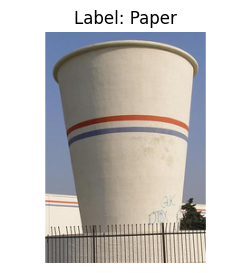

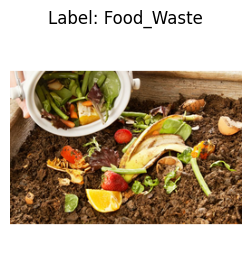

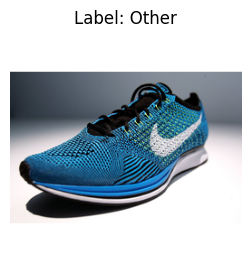

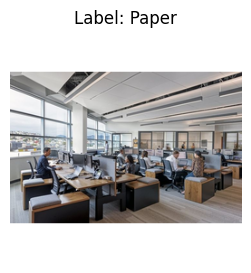

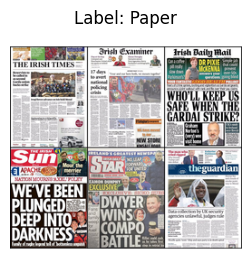

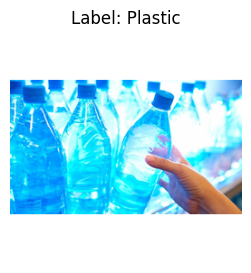

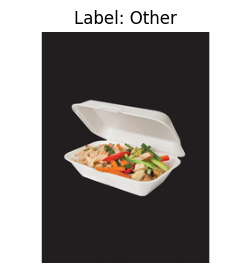

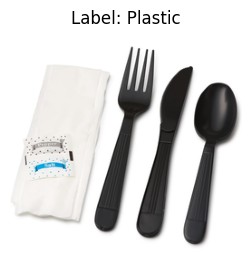

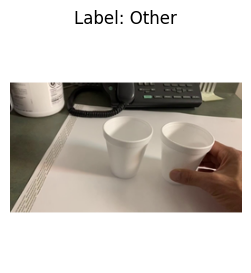

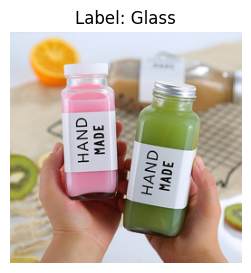

In [ ]:
for i in range(0, 10):
    idx = random.randint(0, len(images_numpy))
    plot_image(images_numpy[idx], labels_numpy[idx])


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set
min_height = float('inf')
min_width = float('inf')
max_height = 0
max_width = 0

for image in images_numpy:
    height, width, _ = image.shape
    min_height = min(min_height, height)
    min_width = min(min_width, width)
    max_height = max(max_height, height)
    max_width = max(max_width, width)

print(f"Smallest dimensions: Height = {min_height}, Width = {min_width}")
print(f"Largest dimensions: Height = {max_height}, Width = {max_width}")

Smallest dimensions: Height = 256, Width = 256
Largest dimensions: Height = 256, Width = 256


In [ ]:
# Resize the image dimensions

IMG_WIDTH = 100
IMG_HEIGHT = 100

resized_images = []
for image in images_numpy:
    resized_image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH)).numpy()
    resized_images.append(resized_image)

images_numpy = np.array(resized_images)

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably

encoder = LabelEncoder()
labels_numpy = encoder.fit_transform(labels_numpy)


In [ ]:
labels_numpy

array([3, 3, 3, ..., 5, 5, 5])

In [ ]:
num_classes = len(np.bincount(labels_numpy))

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets
# Splitting the dataset in train, validation and test sets
# 70% is train dataset, 15% is validation and 15% test
X_train, X_val, y_train, y_val = train_test_split(images_numpy, labels_numpy, test_size=0.3, stratify=labels_numpy, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.3, stratify=y_val, random_state=42)

In [ ]:
X_train /= 255
X_val /= 255
X_test /=255

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

### Model 1 - 3 Convolution layers
Trained model with 3 convolution layers, 1 flatten layer and 1 output layer. Convolution layers has relu activation function, flatten layer has relu activation function and output layer has softmax activation function


In [ ]:
model = Sequential()
reg = 0.0001

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
# To train this model, you would compile it and fit it to your data:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Create the augmented training dataset
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_132 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_133 (Activation)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_134 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_135 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 7)              │         1,799 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_136 (Activation)     │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,814,791 (18.37 MB)

 Trainable params: 4,814,343 (18.37 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.2833 - loss: 2.6772 - val_accuracy: 0.3144 - val_loss: 2.2512 - learning_rate: 3.0000e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3985 - loss: 1.6782 - val_accuracy: 0.4425 - val_loss: 1.5907 - learning_rate: 3.0000e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4304 - loss: 1.6070 - val_accuracy: 0.4367 - val_loss: 1.5178 - learning_rate: 3.0000e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4737 - loss: 1.5082 - val_accuracy: 0.4614 - val_loss: 1.5091 - learning_rate: 3.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5005 - loss: 1.4043 - val_accuracy: 0.5022 - val_loss: 1.4266 - learning_rate: 3.0000e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5184 - loss: 1.3461 - val_accuracy: 0.5357 - val_loss: 1.3959 - learning_rate: 3.0000e-04
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - ac

#### Conclusion -
Since there is significant difference in training(~88%) and validation(~67%) accuracy, hence model is overfitting.

### Model 2 - 5 convolution layers


In [ ]:
model = Sequential()
reg = 0.0001

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(reg)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
# To train this model, you would compile it and fit it to your data:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Create the augmented training dataset
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, reduce_lr])


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_87 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_137 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_138 (Activation)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_139 (Activation)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_140 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 25, 25, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_141 (Activation)     │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_142 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,565,959 (9.79 MB)

 Trainable params: 2,565,639 (9.79 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.2666 - loss: 2.4866 - val_accuracy: 0.3217 - val_loss: 1.8449 - learning_rate: 3.0000e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3743 - loss: 1.7375 - val_accuracy: 0.4265 - val_loss: 1.5331 - learning_rate: 3.0000e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4235 - loss: 1.6529 - val_accuracy: 0.4571 - val_loss: 1.5054 - learning_rate: 3.0000e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4526 - loss: 1.5503 - val_accuracy: 0.4745 - val_loss: 1.5037 - learning_rate: 3.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4817 - loss: 1.4702 - val_accuracy: 0.5036 - val_loss: 1.4343 - learning_rate: 3.0000e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5225 - loss: 1.4003 - val_accuracy: 0.5138 - val_loss: 1.4369 - learning_rate: 3.0000e-04
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - ac

#### Conclusion -
Model is still overfitting since there is significant difference in training and validation accuracy.

### Model 3 : Model with 7 convolution layers and different values of learning rate, regularisation, filter and number of neurons in dense layer

In [ ]:
def build_model_with_different_params(reg, lr, dense_layer, filter):
  model = Sequential()
  reg = reg
  filter = filter
  model.add(Conv2D(32, filter, padding='same',
                  input_shape=X_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(64, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))


  model.add(Conv2D(128, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Conv2D(128, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))


  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))


  model.summary()
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  # To train this model, you would compile it and fit it to your data:
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  # Create the augmented training dataset
  model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, reduce_lr])
  return model

### Model 3.1 : Configuration 1


In [ ]:
build_model_with_different_params(0.00005, 1e-4, 128, (1, 2))

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_92 (Conv2D)              │ (None, 100, 100, 32)   │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_144 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 100, 100, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_145 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 100, 100, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_146 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 50, 50, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_147 (Activation)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 50, 50, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_148 (Activation)     │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 25, 25, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_149 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 25, 25, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_150 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,414,983 (9.21 MB)

 Trainable params: 2,414,599 (9.21 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.2398 - loss: 2.3202 - val_accuracy: 0.1354 - val_loss: 3.8351 - learning_rate: 1.0000e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3145 - loss: 1.7783 - val_accuracy: 0.3464 - val_loss: 1.9372 - learning_rate: 1.0000e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3655 - loss: 1.6788 - val_accuracy: 0.4221 - val_loss: 1.6802 - learning_rate: 1.0000e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3885 - loss: 1.6376 - val_accuracy: 0.4090 - val_loss: 1.6225 - learning_rate: 1.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4167 - loss: 1.5584 - val_accuracy: 0.4192 - val_loss: 1.6348 - learning_rate: 1.0000e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4492 - loss: 1.5001 - val_accuracy: 0.4469 - val_loss: 1.7098 - learning_rate: 1.0000e-04
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - ac

<Sequential name=sequential_16, built=True>

### Model 3.2 : Configuration 2


In [ ]:
build_model_with_different_params(0.0001, 3e-4, 256, (3, 3))

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_99 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_153 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_154 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_156 (Activation)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_157 (Activation)     │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 25, 25, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_158 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_159 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,602,023 (9.93 MB)

 Trainable params: 2,601,639 (9.92 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.2605 - loss: 2.3495 - val_accuracy: 0.3042 - val_loss: 1.9543 - learning_rate: 3.0000e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.3265 - loss: 1.8148 - val_accuracy: 0.3450 - val_loss: 1.7670 - learning_rate: 3.0000e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3434 - loss: 1.7644 - val_accuracy: 0.1921 - val_loss: 2.9667 - learning_rate: 3.0000e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3625 - loss: 1.7412 - val_accuracy: 0.2591 - val_loss: 2.1412 - learning_rate: 3.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3805 - loss: 1.6583 - val_accuracy: 0.3188 - val_loss: 2.2743 - learning_rate: 3.0000e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3860 - loss: 1.6304 - val_accuracy: 0.4265 - val_loss: 1.6084 - learning_rate: 1.5000e-04
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - 

<Sequential name=sequential_17, built=True>

### Model 3.3 : Configuration 3

In [ ]:
best_model = build_model_with_different_params(0.0002, 3e-4, 128, (3, 3))

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_106 (Conv2D)             │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_162 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_163 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_164 (Activation)     │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_165 (Activation)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_166 (Activation)     │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 25, 25, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_167 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_168 (Activation)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,602,023 (9.93 MB)

 Trainable params: 2,601,639 (9.92 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.2634 - loss: 2.4329 - val_accuracy: 0.2911 - val_loss: 2.4931 - learning_rate: 3.0000e-04
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3433 - loss: 1.8515 - val_accuracy: 0.3348 - val_loss: 1.9716 - learning_rate: 3.0000e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3405 - loss: 1.8257 - val_accuracy: 0.3712 - val_loss: 1.7363 - learning_rate: 3.0000e-04
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3627 - loss: 1.7729 - val_accuracy: 0.3843 - val_loss: 1.7422 - learning_rate: 3.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3923 - loss: 1.6954 - val_accuracy: 0.4003 - val_loss: 1.6744 - learning_rate: 3.0000e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.4045 - loss: 1.6709 - val_accuracy: 0.4381 - val_loss: 1.6370 - learning_rate: 3.0000e-04
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - a

#### Conclusion -
Tried different models with different parameters like learning rate, filter, number of neurons in dense layers.
- Model 3.1 had low train and validation accuracy
- Model 3.2 was overfitting
- Model 3.3 had 71% training accuracy and 65% validation accuracy.

**With Model 4, will try to improve the train and validation accuracy**

### Model 4 : Models with more dense layers (Best ***Model*** achieved)

In [ ]:
def build_model_with_more_layers(reg, lr, dense_layer, filter):
  model = Sequential()
  reg = reg
  filter = filter
  model.add(Conv2D(32, filter, padding='same',
                  input_shape=X_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(64, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))


  model.add(Conv2D(128, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Conv2D(128, filter, padding='same', kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(256, kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dense(256, kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer=l2(reg)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))


  model.summary()
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

  opt = tf.keras.optimizers.Adam(learning_rate=lr)
  # To train this model, you would compile it and fit it to your data:
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  # Create the augmented training dataset
  history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, reduce_lr])
  return model, history

In [ ]:
best_model, history = build_model_with_more_layers(0.0003, 3e-4, 128, (3, 3))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 25, 25, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 636,455 (2.43 MB)

 Trainable params: 636,071 (2.43 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - accuracy: 0.2499 - loss: 2.3280 - val_accuracy: 0.3013 - val_loss: 2.1839 - learning_rate: 3.0000e-04
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3202 - loss: 2.0311 - val_accuracy: 0.3013 - val_loss: 2.2036 - learning_rate: 3.0000e-04
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3385 - loss: 1.9704 - val_accuracy: 0.3159 - val_loss: 2.0826 - learning_rate: 3.0000e-04
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.3509 - loss: 1.9429 - val_accuracy: 0.4017 - val_loss: 1.8927 - learning_rate: 3.0000e-04
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3835 - loss: 1.8513 - val_accuracy: 0.4367 - val_loss: 1.8035 - learning_rate: 3.0000e-04
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4135 - loss: 1.8014 - val_accuracy: 0.3217 - val_loss: 2.0604 - learning_rate: 3.0000e-04
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step 

Conclusion - After adding more dense layers finally we were acle to achieve 79.35% training accuracy and 71.62% accuracy on validation dataset.

### Model 5 : Using Transfer Learning
Used for experimentation and not used for evaluation over testing dataset.


In [ ]:
def get_trained_model(input_shape):
    # Get base model
    # Here we are using VGG16 as base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # As we are using VGG16 model only for feature extraction and not adjusting the weights
    # we freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get base model output
    x = base_model.output

    # Adding our own layers after the base model's output with 'same' padding
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002))(x)
    x = GlobalAveragePooling2D()(x)
    # Removed the last MaxPooling2D layer here

    # Adding fully connected layer
    x = Flatten()(x) # Flatten the output before the dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x) # Added dropout after the dense layer
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
# Get the model
# Pass the input shape to the get_trained_model function
trained_model = get_trained_model(X_train.shape[1:])
# Compile it
trained_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Summary of model
trained_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_610"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 3, 3, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 1, 1, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,891,911 (56.81 MB)

 Trainable params: 177,223 (692.28 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
trained_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.2659 - loss: 2.0847 - val_accuracy: 0.3013 - val_loss: 2.0180 - learning_rate: 0.0100
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.2936 - loss: 2.0317 - val_accuracy: 0.3013 - val_loss: 1.9874 - learning_rate: 0.0100
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2988 - loss: 1.9807 - val_accuracy: 0.3013 - val_loss: 1.9305 - learning_rate: 0.0100
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.3094 - loss: 1.9129 - val_accuracy: 0.3566 - val_loss: 1.8707 - learning_rate: 0.0100
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.3506 - loss: 1.8452 - val_accuracy: 0.4250 - val_loss: 1.7694 - learning_rate: 0.0100
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.3907 - loss: 1.7652 - val_accuracy: 0.4119 - val_loss: 1.7724 - learning_rate: 0.0100
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4353 - lo

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics


print("Evaluating on the Testing set:")
results = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {results[0]}")
print(f"Testing Accuracy: {results[1]}")

Evaluating on the Testing set:
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6704 - loss: 1.1894
Testing Loss: 1.2056266069412231
Testing Accuracy: 0.6777014136314392


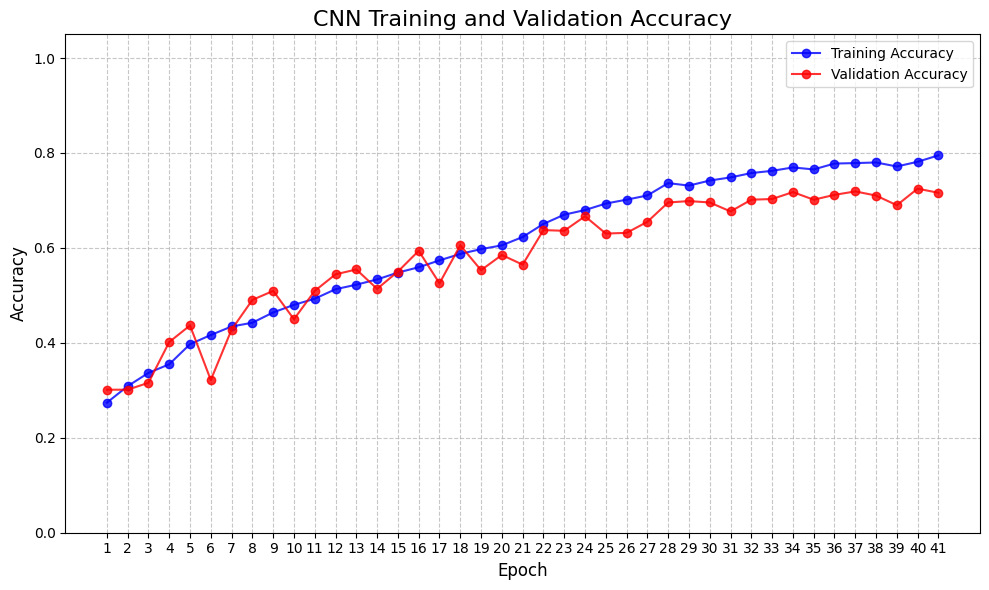

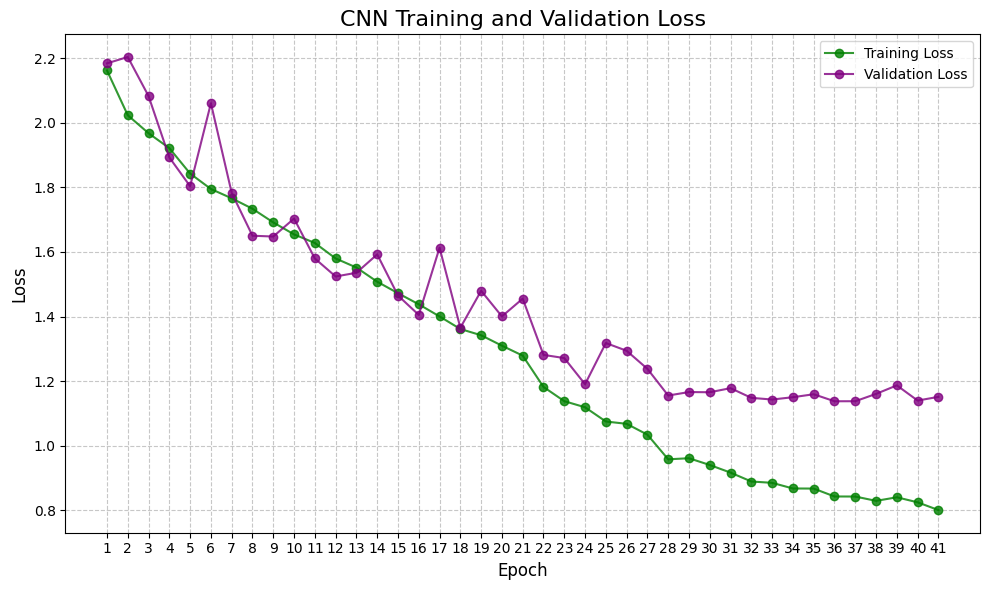

In [ ]:
# Plot accuracy

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'o-', label='Training Accuracy', color='blue', alpha=0.8)
plt.plot(epochs, val_accuracy, 'o-', label='Validation Accuracy', color='red', alpha=0.8)

plt.title('CNN Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.xticks(epochs)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

# Plot Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'o-', label='Training Loss', color='green', alpha=0.8)
plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color='purple', alpha=0.8)
plt.title('CNN Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

#### Problem Statement :

Improper waste disposal leads to environmental degradation and inefficient recycling. An AI-powered waste classification system offers a solution by automating waste segregation, which significantly reduces labor and costs while boosting recycling rates through precise classification. This technology is ideal for smart recycling bins and automated sorting facilities.

### Observations

1. Data Preparation:
    * Images were converted into NumPy arrays.
    * Labels were extracted from subdirectory names and stored in a separate array.
    * Images were rescaled to 100x100 pixels to decrease model training time.
2. Dataset Characteristics:
    * constituting approximately 33.33% and cardboard images around 6%.
3. Data Splitting:
    * The dataset was divided into training (70%), validation (15%), and test (15%) sets.
4. Label Encoding:
    * LabelCoder was used for encoding the labels.
5. Model Training & Performance:
    * Multiple model configurations were trained.
    * The best-performing model achieved:
    * 79.35% training accuracy
    * 71.62% validation accuracy
    * 67.77% accuracy on the test data